In [1]:
from IPython.display import HTML
import numpy as np
import urllib
import bs4
import time
import operator
import socket
import pickle
import re

from pandas import Series
import pandas as pd
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

In [2]:
#url postings for data scientist job in indeed.com(US)
url = 'http://www.indeed.com/jobs?q=junior+data+scientist&start='
#Reading source from the site
source = urllib.request.urlopen(url).read()
#Parse through beautiful soup
bs_source = bs4.BeautifulSoup(source, "lxml")
#Search for the entire result, so that we may apply search for the entirety
job_count= bs_source.find(id = 'searchCount').contents[0]
job_count= job_count.split()[-1]
print('Total of ' + job_count + ' jobs found')
#Turn job_count into an int
job_count_int = int(job_count.replace(',',''))
print(job_count_int)

Total of 1,214 jobs found
1214


In [18]:
#The website shows 10 results per page, and the url scrolls by increasing by 10 per page(ex. ...&start=10 (page 2), ...&start=20 (page 3))
num_pages = int(job_count_int/10)
#first things first, all links to job description link must be listed up to search for each result
job_links = []
base_url = 'http://www.indeed.com/rc/clk?jk='
for i in range(num_pages): #num_pages
    url = 'http://www.indeed.com/jobs?q=junior+data+scientist&start=' + str(i*10)
    page = urllib.request.urlopen(url).read()
    bs_page = bs4.BeautifulSoup(page, "lxml")
    job_link_area = bs_page.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                    and ''.join(jp.get('class')) =="rowresult"]
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    for id in job_ids:
        job_links.append(base_url + id)

    time.sleep(1)
print(job_links)
    


['http://www.indeed.com/rc/clk?jk=1a11bd8fbe3b50ce', 'http://www.indeed.com/rc/clk?jk=f81ae03425008f71', 'http://www.indeed.com/rc/clk?jk=acce68fa735f50b1', 'http://www.indeed.com/rc/clk?jk=fab31289e4f6aeb3', 'http://www.indeed.com/rc/clk?jk=2cb218213ebed890', 'http://www.indeed.com/rc/clk?jk=a71a973710d85f7d', 'http://www.indeed.com/rc/clk?jk=0bb5be93ae96f543', 'http://www.indeed.com/rc/clk?jk=2040c42b26af0034', 'http://www.indeed.com/rc/clk?jk=30d95988866908c5', 'http://www.indeed.com/rc/clk?jk=59a48041112c03e3', 'http://www.indeed.com/rc/clk?jk=6ee73d635a96eec1', 'http://www.indeed.com/rc/clk?jk=3a3b1ecd60026be1', 'http://www.indeed.com/rc/clk?jk=d5d82d2f6d6180cc', 'http://www.indeed.com/rc/clk?jk=9116d124fb59f6a3', 'http://www.indeed.com/rc/clk?jk=d7f738ff7e680224', 'http://www.indeed.com/rc/clk?jk=68991541bb649b4e', 'http://www.indeed.com/rc/clk?jk=7a6a3e8f0c6c7301', 'http://www.indeed.com/rc/clk?jk=e7c544317b06657c', 'http://www.indeed.com/rc/clk?jk=5dab68a7d68e12da', 'http://www

In [87]:
# save using pickle for serialization
pickle.dump(job_links, open('saved_links.p', 'wb'))

# load dumped job_links
job_links = pickle.load(open('saved_links.p', 'rb'))

In [92]:
skill_set = {'R':0, 'Python':0,'JavaScript':0, 'Scala':0, 'Excel':0, 'Tableau':0, 'SAS':0, 'SPSS':0, 
             'MySQL':0, 'Hadoop':0, 'MapReduce':0, 'Spark':0, 'Hive':0, 'SQL':0, 'NoSQL':0, 'Pig':0}


In [93]:
#save to serialize & use for restart
pickle.dump((skill_set,0), open('skill_set_restart.p', 'wb'))

In [94]:
skill_set, index = pickle.load(open('skill_set_restart.p', 'rb'))

In [95]:
counter = 0

for link in job_links[index:]:
    counter +=1  
    
    try:
        html_page = urllib.request.urlopen(link).read()
    except urllib.error.HTTPError:
        print("HTTPError:")
        continue
    except urllib.error.URLError:
        print ("URLError:")
        continue
    except socket.error as error:
        print ("Connection closed")
        continue
    
    bs_html_page = bs4.BeautifulSoup(html_page,'lxml')
    
    for script in bs_html_page(["script", "style"]):
        script.extract()    # rip it out

    # get text
    text = bs_html_page.get_text()

    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    html_text = '\n'.join(chunk for chunk in chunks if chunk)
    
    html_text = re.sub("[^a-zA-Z]"," ", html_text)
    
    for key in skill_set.keys():
        if key is 'R':             # to prevent 'R' in words counted as 'R'
            if ' R ' in html_text: 
                skill_set['R'] +=1
        else:
            if key in html_text:  
                skill_set[key] +=1
            
    if counter % 5 == 0:
        print (len(job_links) - counter - index)
        print (skill_set)
        with open('skill_set_restart.p','wb') as f:
            pickle.dump((skill_set, index+counter),f)

1084
{'R': 3, 'Excel': 0, 'JavaScript': 1, 'Hadoop': 0, 'Pig': 0, 'NoSQL': 0, 'Hive': 0, 'Python': 4, 'SAS': 3, 'MapReduce': 0, 'Tableau': 0, 'Spark': 0, 'MySQL': 0, 'SPSS': 1, 'SQL': 1, 'Scala': 0}
HTTPError:
1079
{'R': 4, 'Excel': 0, 'JavaScript': 1, 'Hadoop': 0, 'Pig': 0, 'NoSQL': 0, 'Hive': 0, 'Python': 6, 'SAS': 4, 'MapReduce': 0, 'Tableau': 0, 'Spark': 0, 'MySQL': 1, 'SPSS': 1, 'SQL': 2, 'Scala': 0}
1074
{'R': 6, 'Excel': 1, 'JavaScript': 1, 'Hadoop': 2, 'Pig': 0, 'NoSQL': 1, 'Hive': 1, 'Python': 9, 'SAS': 7, 'MapReduce': 2, 'Tableau': 2, 'Spark': 1, 'MySQL': 2, 'SPSS': 1, 'SQL': 5, 'Scala': 0}
HTTPError:
1069
{'R': 9, 'Excel': 1, 'JavaScript': 2, 'Hadoop': 4, 'Pig': 0, 'NoSQL': 1, 'Hive': 1, 'Python': 12, 'SAS': 8, 'MapReduce': 2, 'Tableau': 2, 'Spark': 2, 'MySQL': 2, 'SPSS': 1, 'SQL': 7, 'Scala': 0}
1064
{'R': 10, 'Excel': 3, 'JavaScript': 3, 'Hadoop': 6, 'Pig': 0, 'NoSQL': 1, 'Hive': 2, 'Python': 15, 'SAS': 8, 'MapReduce': 2, 'Tableau': 3, 'Spark': 3, 'MySQL': 2, 'SPSS': 1, 'S

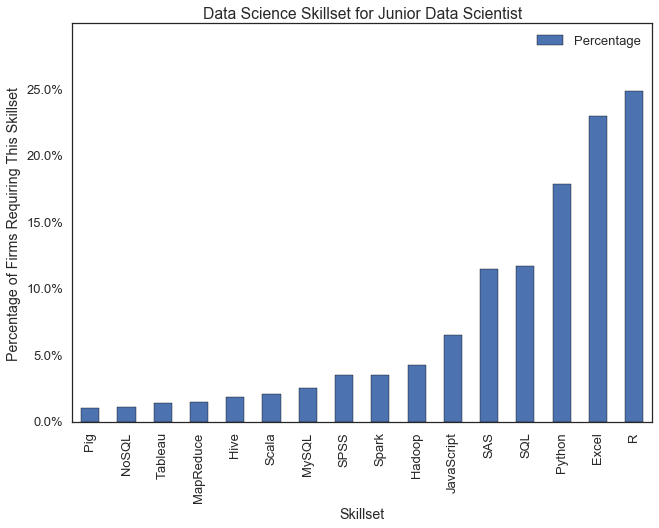

In [123]:
pseries = pd.Series(skill_set)
pseries.sort_values(inplace=True)

ax = pseries.apply(lambda f: f/counter * 100).apply(lambda e: round(e,2)).to_frame('Percentage').plot(kind = 'bar')
vals = ax.get_yticks()
ax.set_yticklabels(['{:2}%'.format(x) for x in vals])

## set the title to Score Comparison
plt.title('Data Science Skillset for Junior Data Scientist')
plt.xlabel('Skillset')
plt.ylabel('Percentage of Firms Requiring This Skillset')
plt.ylim(0, 30)
plt.show()